## Análisis de cancelación de clientes (Churn)

El objetivo de este análisis es identificar los principales factores asociados
a la cancelación de clientes en una empresa de telecomunicaciones, comparando
características demográficas, contractuales y de facturación.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"


# **LIMPIEZA Y REFINACION DE LOS DATOS**

In [2]:
df = pd.read_json(url)
df_normalizado = pd.json_normalize(df.to_dict(orient="records"))

print(df_normalizado.shape)
print(df_normalizado.head())

(7267, 21)
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.InternetSe

In [3]:
columnas_nuevas = {
    "customerID": "ID",
    "Churn": "Cliente_cancelo",
    "customer.gender": "género",
    "customer.SeniorCitizen": "Mayor_65",
    "customer.Partner": "pareja",
    "customer.Dependents": "dependientes",
    "customer.tenure": "meses_contrato",
    "phone.PhoneService": "servicio_telefónico",
    "phone.MultipleLines": "dos_o_mas_lineas",
    "internet.InternetService": "proveedor_internet",
    "internet.OnlineSecurity": "subs_seg_online",
    "internet.OnlineBackup": "subs_backup",
    "internet.DeviceProtection": "device_protect",
    "internet.TechSupport": "soporte_tecnico",
    "internet.StreamingTV": "subs_tv",
    "internet.StreamingMovies": "subs_streaming",
    "account.Contract": "tipo_contrato",
    "account.PaperlessBilling": "factura_online",
    "account.PaymentMethod": "forma_pago",
    "account.Charges.Monthly": "total_servicios",
    "account.Charges.Total": "gasto_total"
}

df_normalizado.rename(columns=columnas_nuevas, inplace=True)
print(df_normalizado.head())

           ID Cliente_cancelo  género  Mayor_65 pareja dependientes  \
0  0002-ORFBO              No  Female         0    Yes          Yes   
1  0003-MKNFE              No    Male         0     No           No   
2  0004-TLHLJ             Yes    Male         0     No           No   
3  0011-IGKFF             Yes    Male         1    Yes           No   
4  0013-EXCHZ             Yes  Female         1    Yes           No   

   meses_contrato servicio_telefónico dos_o_mas_lineas proveedor_internet  \
0               9                 Yes               No                DSL   
1               9                 Yes              Yes                DSL   
2               4                 Yes               No        Fiber optic   
3              13                 Yes               No        Fiber optic   
4               3                 Yes               No        Fiber optic   

   ... subs_backup device_protect soporte_tecnico subs_tv subs_streaming  \
0  ...         Yes             No 

In [4]:

#convirtiendo los tipos de datos para su eventual manipulacion o lectura para graficar
df_normalizado["total_servicios"] = pd.to_numeric(
    df_normalizado["total_servicios"], errors="coerce")
df_normalizado["gasto_total"] = pd.to_numeric(
    df_normalizado["gasto_total"], errors="coerce")
df_normalizado["Mayor_65"] = df_normalizado["Mayor_65"].astype(bool)
df_normalizado["Cliente_cancelo"] = df_normalizado["Cliente_cancelo"].astype("string")
#print(df_normalizado.tail(100))
#validando tipos de datos, nulos.
df_normalizado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   7267 non-null   object 
 1   Cliente_cancelo      7267 non-null   string 
 2   género               7267 non-null   object 
 3   Mayor_65             7267 non-null   bool   
 4   pareja               7267 non-null   object 
 5   dependientes         7267 non-null   object 
 6   meses_contrato       7267 non-null   int64  
 7   servicio_telefónico  7267 non-null   object 
 8   dos_o_mas_lineas     7267 non-null   object 
 9   proveedor_internet   7267 non-null   object 
 10  subs_seg_online      7267 non-null   object 
 11  subs_backup          7267 non-null   object 
 12  device_protect       7267 non-null   object 
 13  soporte_tecnico      7267 non-null   object 
 14  subs_tv              7267 non-null   object 
 15  subs_streaming       7267 non-null   o

In [5]:
# llenando los datos vacios identificados en el punto anterior.
df_normalizado["gasto_total"] = df_normalizado["gasto_total"].fillna(0)
#df_normalizado.info()

In [6]:
#df_normalizado.to_csv("df_normalizado.csv", index=False)


In [7]:
#validando strings vacios
#df_normalizado["Cliente_cancelo"].value_counts(dropna=False)
df_normalizado["Cliente_cancelo"] = df_normalizado["Cliente_cancelo"].replace("", np.nan)
df_normalizado = df_normalizado.dropna(subset=["Cliente_cancelo"])
#eliminando campos vacios del dato objetivo mas importante (cliente_cancelo)
df_normalizado["Cliente_cancelo"].value_counts(dropna=False)
#convirtiendo a strings los faltantes
cols_string = [
    "ID",
    "dos_o_mas_lineas",
    "proveedor_internet",
    "subs_seg_online",
    "subs_backup",
    "device_protect",
    "soporte_tecnico",
    "subs_tv",
    "subs_streaming",
    "tipo_contrato",
    "forma_pago",
    "género",
    "pareja",
    "dependientes",
    "Cliente_cancelo"
]
df_normalizado[cols_string] = df_normalizado[cols_string].astype("string")
#ahora si podemos convertir a bool cliente_cancelo, despues de eliminar los vacios
#y convertir tambien todas las columnas los que son yes/no en bool
cols_bool = [

    "servicio_telefónico",
    "factura_online"
]
df_normalizado[cols_bool] = df_normalizado[cols_bool].astype("bool")
df_normalizado.info()
# finalizaos con todas las columnas definidas con su respectivo tipo de dato

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   7043 non-null   string 
 1   Cliente_cancelo      7043 non-null   string 
 2   género               7043 non-null   string 
 3   Mayor_65             7043 non-null   bool   
 4   pareja               7043 non-null   string 
 5   dependientes         7043 non-null   string 
 6   meses_contrato       7043 non-null   int64  
 7   servicio_telefónico  7043 non-null   bool   
 8   dos_o_mas_lineas     7043 non-null   string 
 9   proveedor_internet   7043 non-null   string 
 10  subs_seg_online      7043 non-null   string 
 11  subs_backup          7043 non-null   string 
 12  device_protect       7043 non-null   string 
 13  soporte_tecnico      7043 non-null   string 
 14  subs_tv              7043 non-null   string 
 15  subs_streaming       7043 non-null   string

In [8]:
#generando archivo con el df final para evitar problemas en orden de ejecucion mas adelante
df_normalizado.to_csv("df_clean.csv", index=False)
df_csv = pd.read_csv("df_clean.csv")
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   7043 non-null   object 
 1   Cliente_cancelo      7043 non-null   object 
 2   género               7043 non-null   object 
 3   Mayor_65             7043 non-null   bool   
 4   pareja               7043 non-null   object 
 5   dependientes         7043 non-null   object 
 6   meses_contrato       7043 non-null   int64  
 7   servicio_telefónico  7043 non-null   bool   
 8   dos_o_mas_lineas     7043 non-null   object 
 9   proveedor_internet   7043 non-null   object 
 10  subs_seg_online      7043 non-null   object 
 11  subs_backup          7043 non-null   object 
 12  device_protect       7043 non-null   object 
 13  soporte_tecnico      7043 non-null   object 
 14  subs_tv              7043 non-null   object 
 15  subs_streaming       7043 non-null   o

# **Analisis**

empesaremos visualizando datos de perfil de cliente, facturacion, servicios y tiempo. cada una de estas variables comparada con la variable objetivo (churn), nos arrojara los factores que hacen que los clientes cancelen.

In [9]:
# Conteo de perfiles cualitativos de cliente
genero_counts = df_csv["género"].value_counts()
mayor65_counts = df_csv["Mayor_65"].value_counts()
pareja_counts = df_csv["pareja"].value_counts()
dependientes_counts = df_csv["dependientes"].value_counts()
cliente_cancel = df_csv["Cliente_cancelo"].value_counts()
print(genero_counts)
print(mayor65_counts)
print(pareja_counts)
print(dependientes_counts)
print(cliente_cancel)

género
Male      3555
Female    3488
Name: count, dtype: int64
Mayor_65
False    5901
True     1142
Name: count, dtype: int64
pareja
No     3641
Yes    3402
Name: count, dtype: int64
dependientes
No     4933
Yes    2110
Name: count, dtype: int64
Cliente_cancelo
No     5174
Yes    1869
Name: count, dtype: int64


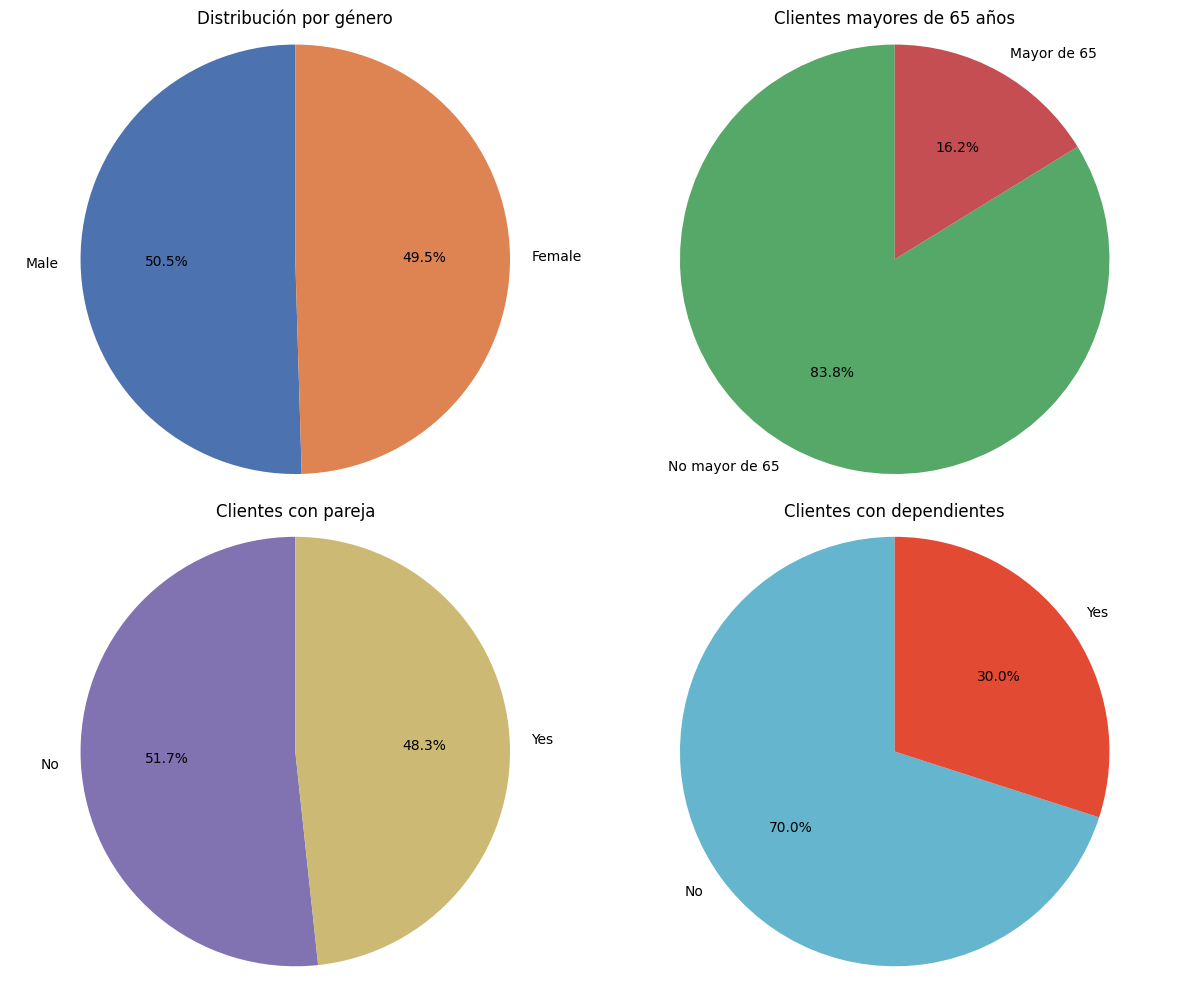

In [10]:
colors_genero = ["#4C72B0", "#DD8452"]        # Azul / Naranja
colors_mayor65 = ["#55A868", "#C44E52"]      # Verde / Rojo
colors_pareja = ["#8172B2", "#CCB974"]       # Morado / Amarillo
colors_dependientes = ["#64B5CD", "#E24A33"] # Celeste / Rojo
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico 1: Género
axes[0, 0].pie(
    genero_counts,
    labels=genero_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_genero
)
axes[0, 0].set_title("Distribución por género")

# Gráfico 2: Mayor de 65
axes[0, 1].pie(
    mayor65_counts,
    labels=["No mayor de 65", "Mayor de 65"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_mayor65
)
axes[0, 1].set_title("Clientes mayores de 65 años")

# Gráfico 3: Pareja
axes[1, 0].pie(
    pareja_counts,
    labels=pareja_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_pareja
)
axes[1, 0].set_title("Clientes con pareja")

# Gráfico 4: Dependientes
axes[1, 1].pie(
    dependientes_counts,
    labels=dependientes_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_dependientes
)
axes[1, 1].set_title("Clientes con dependientes")

# Ajustes finales
for ax in axes.flat:
    ax.axis("equal")

plt.tight_layout()
plt.show()



en la grafica anterior se observa como se distribuyen todos los clientes en las caracteristicas cualitativas, donde la mayoria de edad de 65 es el factor que representa un factor a tener en cuenta para validarlo frente a la tasa dedesercion.

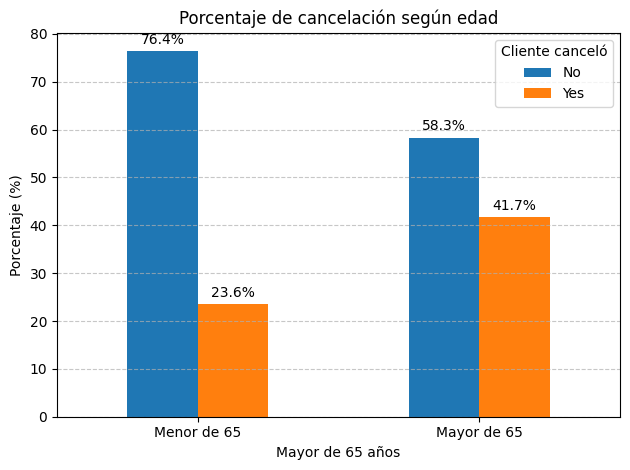

In [20]:

tabla = pd.crosstab(df_csv['Mayor_65'], df_csv['Cliente_cancelo'])
tabla = tabla.div(tabla.sum(axis=1), axis=0) * 100
tabla.index = ['Menor de 65', 'Mayor de 65']

ax = tabla.plot(kind='bar')
plt.title('Porcentaje de cancelación según edad')
plt.xlabel('Mayor de 65 años')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Cliente canceló')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 👉 Añadir valores encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()




la grafica anterior muestra que el porcentaje de las pesronas que cancelan menores de 65 años es muy alto, incluso superando el 52% de diferencia frente a las personas que no cancelan en el mismo rango de edad.

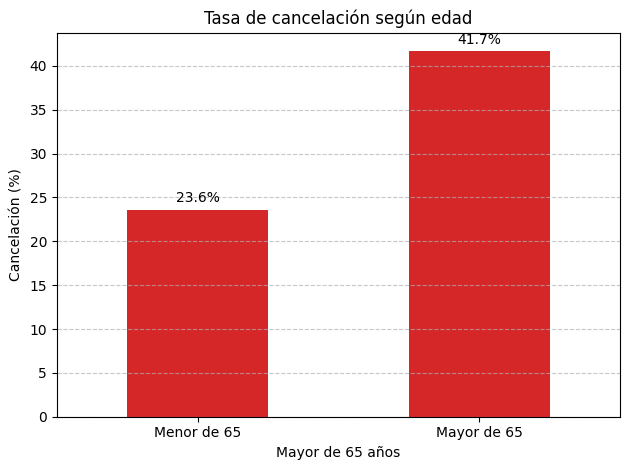

In [21]:
churn_rate = tabla['Yes']
ax = churn_rate.plot(kind='bar', color='#d62728')
plt.title('Tasa de cancelación según edad')
plt.xlabel('Mayor de 65 años')
plt.ylabel('Cancelación (%)')
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

en la figura anterior se muestra la tassa de cancelacion en personas menores de 65 años, y vemos como es un % muy alto, mostrandonos que es un punto a tener en cuenta para un plan de mejora.

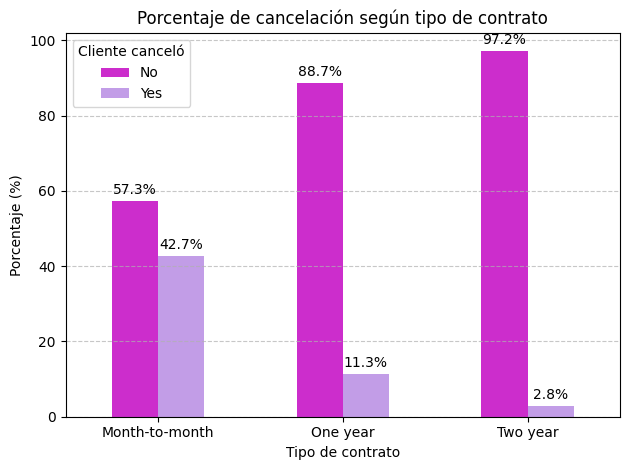

In [13]:
tabla_contrato = pd.crosstab(
    df_csv['tipo_contrato'],
    df_csv['Cliente_cancelo']
)
tabla_contrato_pct = tabla_contrato.div(
    tabla_contrato.sum(axis=1),
    axis=0
) * 100
ax = tabla_contrato_pct.plot(kind='bar',color=['#CC2DCC', '#C29DE7'])

plt.title('Porcentaje de cancelación según tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Cliente canceló')
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Valores encima de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()


Los clientes con contratos mensuales presentan una tasa de cancelación significativamente mayor en comparación con aquellos con contratos anuales o bianuales, lo que indica que la falta de compromiso a largo plazo es uno de los principales factores del churn.

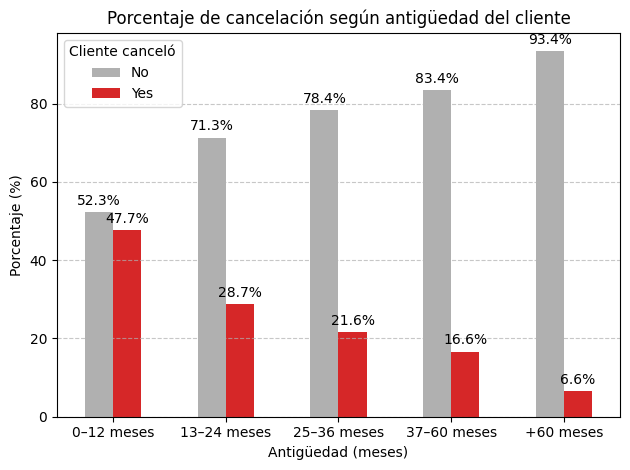

In [14]:
df_csv['rango_meses'] = pd.cut(
    df_csv['meses_contrato'],
    bins=[0, 12, 24, 36, 60, 100],
    labels=[
        '0–12 meses',
        '13–24 meses',
        '25–36 meses',
        '37–60 meses',
        '+60 meses'
    ]
)
tabla_meses = pd.crosstab(
    df_csv['rango_meses'],
    df_csv['Cliente_cancelo']
)

tabla_meses_pct = tabla_meses.div(tabla_meses.sum(axis=1), axis=0) * 100
churn_meses = tabla_meses_pct['Yes']

ax = tabla_meses_pct.plot(
    kind='bar',
    color=['#b0b0b0', '#d62728']  # Azul = No / Rojo = Sí
)

plt.title('Porcentaje de cancelación según antigüedad del cliente')
plt.xlabel('Antigüedad (meses)')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Cliente canceló')
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Valores encima de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()



Los clientes con contratos mensuales presentan una tasa de cancelación considerablemente mayor que aquellos con contratos anuales o bianuales, lo que indica que la duración del contrato es un factor determinante en la retención de clientes.

/tmp/ipython-input-4007837777.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


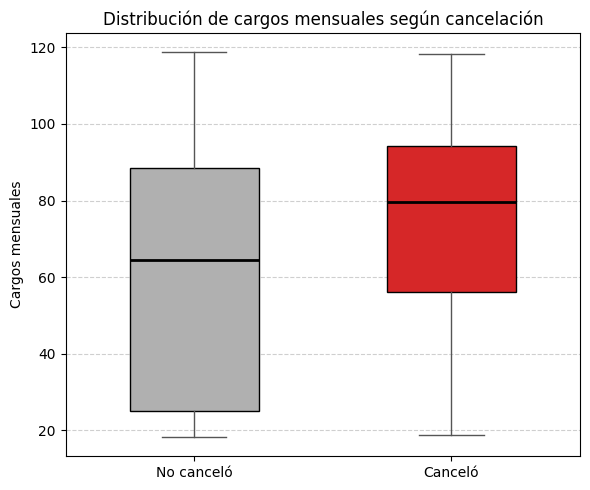

In [15]:

# Separar datos
no_churn = df_csv[df_csv['Cliente_cancelo'] == 'No']['total_servicios']
churn = df_csv[df_csv['Cliente_cancelo'] == 'Yes']['total_servicios']

plt.figure(figsize=(6,5))

box = plt.boxplot(
    [no_churn, churn],
    labels=['No canceló', 'Canceló'],
    patch_artist=True,
    widths=0.5
)

# Colores
colors = ['#b0b0b0', '#d62728']  # gris / rojo
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Estilo de líneas
for element in ['whiskers', 'caps']:
    plt.setp(box[element], color='#555555')

# Mediana destacada
plt.setp(box['medians'], color='black', linewidth=2)

# Outliers
plt.setp(box['fliers'], marker='o', markersize=4, alpha=0.4)

plt.title('Distribución de cargos mensuales según cancelación')
plt.ylabel('Cargos mensuales')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Los clientes que cancelan presentan, en promedio, cargos mensuales más altos que aquellos que permanecen, lo que sugiere que el costo del servicio es un factor relevante en la decisión de cancelación.

**Conclusión**

* Los clientes con contratos mensuales presentan la mayor tasa de cancelación.

* El churn es más alto durante los primeros 12 meses de relación con el cliente.

* Los clientes que cancelan tienen cargos mensuales más elevados, lo que sugiere sensibilidad al precio.


--El análisis evidencia que la cancelación de clientes está fuertemente asociada a variables contractuales y económicas. Los contratos mensuales y la baja antigüedad concentran las mayores tasas de churn, especialmente durante los primeros 12 meses. Adicionalmente, los clientes que cancelan presentan cargos mensuales más altos, lo que indica que el precio y la percepción de valor influyen en la decisión de cancelación. La edad también muestra una relación con el churn, aunque con menor impacto que las variables contractuales.--

**Recomendaciones**

* Implementar estrategias de retención temprana para clientes nuevos (primeros 12 meses).

* Incentivar la migración de contratos mensuales a contratos anuales mediante descuentos o beneficios.

* Revisar la estructura de precios para clientes con cargos mensuales elevados.

* Diseñar campañas específicas para segmentos con mayor riesgo de churn, como clientes mayores de 65 años.